In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold


from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

from functools import partial

import os
import gc
print(os.listdir("../input"))
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

['ieee-fraud-detection']
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv


# 1. Data Loading and preprocessing

## Utility functions:
* Memory reduction (the original dataset is gigantic!)
* PCA (dimension reduction - original # cols > 300)

In [5]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def PCA_change(df, cols, n_components, prefix='PCA_', seed=123):
    pca = PCA(n_components=n_components, random_state=seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df


### Load transaction data (train/test)

In [6]:
df_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
df_test_trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv', index_col='TransactionID')

In [7]:
df_trans.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_test_trans.head()

## Reduce memory usage

In [8]:
### Reduce memory usage of dataset
df_trans = reduce_mem_usage(df_trans)
df_test_trans = reduce_mem_usage(df_test_trans)

Mem. usage decreased to 544.60 Mb (69.3% reduction)
Mem. usage decreased to 474.52 Mb (68.8% reduction)


## Concatenating train and test

In [9]:
df_test_trans['isFraud'] = 'test'
df = pd.concat([df_trans, df_test_trans], axis=0, sort=False )
df = df.reset_index()

In [10]:
for i in df.columns:
    print(i, df[i].dtypes, df[i].isnull().sum(), df[i].nunique())

TransactionID int64 0 1097231
isFraud object 0 3
TransactionDT int32 0 1068035
TransactionAmt float16 0 9131
ProductCD object 0 5
card1 int16 0 17091
card2 float16 17587 501
card3 float16 4567 133
card4 object 4663 4
card5 float16 8806 138
card6 object 4578 4
addr1 float16 131315 441
addr2 float16 131315 93
dist1 float16 643488 2479
dist2 float16 1023168 2212
P_emaildomain object 163648 60
R_emaildomain object 824070 60
C1 float16 3 1964
C2 float16 3 1706
C3 float16 3 32
C4 float16 3 1495
C5 float16 3 353
C6 float16 3 1537
C7 float16 3 1301
C8 float16 3 1296
C9 float16 3 360
C10 float16 3 1278
C11 float16 3 1677
C12 float16 3 1373
C13 float16 4748 1558
C14 float16 3 1150
D1 float16 7300 642
D2 float16 515566 642
D3 float16 466020 888
D4 float16 245773 1069
D5 float16 534216 961
D6 float16 899261 1076
D7 float16 998181 905
D8 float16 947967 5828
D9 float16 947967 24
D10 float16 88567 1075
D11 float16 455805 887
D12 float16 963260 868
D13 float16 911895 827
D14 float16 919850 1036
D15 fl

V327 float16 938449 32
V328 float16 938449 86
V329 float16 938449 126
V330 float16 938449 107
V331 float32 938449 2092
V332 float32 938449 3233
V333 float32 938449 2491
V334 float16 938449 220
V335 float16 938449 1010
V336 float16 938449 503
V337 float32 938449 437
V338 float32 938449 794
V339 float32 938449 624


### Try this: Remove the feature if there are too many missing values for this feature

In [11]:
num_samples=df.shape[0]
threshold = 0.98*num_samples
for col in df.columns:
    if df[col].isnull().sum() > threshold:
        del df[col]

# 2. Dimension Reduction and Feature Selection

## Apply PCA to V1 to V339 (all of them are float types)

In [12]:
#Fitting the PCA algorithm with our Data - determine the appropriate number of components

mas_v = ['V{}'.format(i) for i in range(1,340)]

# standardize the data and fill missing values first 
for col in mas_v:
    df[col].fillna((df_trans[col].median()), inplace=True)
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))
    df_trans[col].fillna((df_trans[col].median()), inplace=True)
    df_trans[col] = (minmax_scale(df_trans[col], feature_range=(0,1)))
v_data = df_trans[mas_v].values
pca = PCA().fit(v_data)

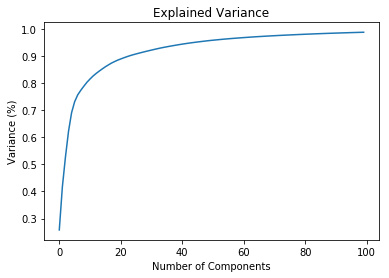

In [13]:
# select the appropriate number of components by eyeballing the variance chart
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_[:100]))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

### We will select 30 components as they already capture >90% of the variance

In [14]:
df = PCA_change(df, mas_v, prefix='PCA_V_', n_components=30)

## Apply PCA to C1 to C14 (all of them are float types)

In [15]:
c_feat = ['C' + str(i) for i in range(1,15)]

for col in c_feat:
    df[col].fillna((df_trans[col].median()), inplace=True)
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))
    df_trans[col].fillna((df_trans[col].median()), inplace=True)
    df_trans[col] = (minmax_scale(df_trans[col], feature_range=(0,1)))
c_data = df_trans[c_feat].values
pca = PCA().fit(c_data)

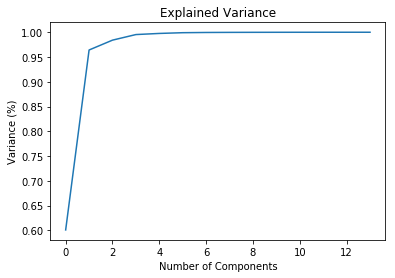

In [16]:
# select the appropriate number of components by eyeballing the variance chart
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

### We will select 2 components as they already capture >95% of the variance

In [17]:
df = PCA_change(df, c_feat, prefix='PCA_C_', n_components=2)

In [18]:
df = reduce_mem_usage(df)
df.shape

Mem. usage decreased to 251.14 Mb (45.0% reduction)


(1097231, 73)

# Apply PCA to D1 to D15 (all of them are float types)
# We can also skip this (try it!)

In [19]:
d_feat = ['D' + str(i) for i in range(1,16)]

for col in d_feat:
    df[col].fillna((df_trans[col].median()), inplace=True)
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))
    df_trans[col].fillna((df_trans[col].median()), inplace=True)
    df_trans[col] = (minmax_scale(df_trans[col], feature_range=(0,1)))
d_data = df_trans[d_feat].values
pca = PCA().fit(d_data)

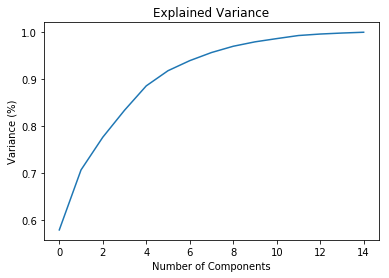

In [20]:
# select the appropriate number of components by eyeballing the variance chart
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

### We will select 8 components as they already capture >95% of the variance

In [21]:
df = PCA_change(df, d_feat, prefix='PCA_D_', n_components=8)

In [22]:
df = reduce_mem_usage(df)
df.shape

Mem. usage decreased to 236.49 Mb (17.5% reduction)


(1097231, 66)

# M features
- Only feeling Na's

In [23]:
m_feat = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

for col in m_feat:
    df[col].fillna('None', inplace=True)

## Handle Email Features

In [24]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
          'scranton.edu': 'other', 'netzero.net': 'other',
          'optonline.net': 'other', 'comcast.net': 'other', 
          'cfl.rr.com': 'other', 'sc.rr.com': 'other',
          'suddenlink.net': 'other', 'windstream.net': 'other',
          'gmx.de': 'other', 'earthlink.net': 'other', 
          'servicios-ta.com': 'other', 'bellsouth.net': 'other', 
          'web.de': 'other', 'mail.com': 'other',
          'cableone.net': 'other', 'roadrunner.com': 'other', 
          'protonmail.com': 'other', 'anonymous.com': 'other',
          'juno.com': 'other', 'ptd.net': 'other',
          'netzero.com': 'other', 'cox.net': 'other', 
          'hotmail.co.uk': 'microsoft', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 
          'live.com': 'microsoft', 'aim.com': 'aol',
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 
          'hotmail.com': 'microsoft',  
          'hotmail.fr': 'microsoft',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 
          'yahoo.de': 'yahoo', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 
          'msn.com': 'microsoft', 'q.com': 'centurylink',
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 
           'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 
          'embarqmail.com': 'centurylink', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo',
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft',
           'aol.com': 'aol', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

In [25]:
#https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    df[c + '_bin'] = df[c].map(emails)
    df[c + '_suffix'] = df[c].map(lambda x: str(x).split('.')[-1])
    df[c + '_suffix'] = df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [26]:
df.drop(['P_emaildomain', 'R_emaildomain'], axis=1, inplace=True)

# Handle Transaction Date - extract day and hour info

In [27]:
import datetime
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Date"] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
df['_Weekdays'] = df['Date'].dt.dayofweek
df['_Hours'] = df['Date'].dt.hour
df['_Days'] = df['Date'].dt.day
#df.drop(['TransactionDT'],axis=1, inplace=True)

## Card info
*card1,card2, card3, card5 - numeric
*card4 - card type (discover, mastercard, visa)
*card5 - card type (credit/debit)

In [28]:
def corret_card_id(x): 
    x=x.replace('.0','')
    x=x.replace('-999','nan')
    return x

def process_card_info(df_in):

    
    # create card ID by concatenating all 4 cards together
    cards_cols= ['card1', 'card2', 'card3', 'card5']
    for card in cards_cols: 
        if '1' in card: 
            df_in['Card_ID']= df_in[card].map(str)
        else : 
            df_in['Card_ID']+= ' '+df_in[card].map(str)
    
    # sort train data by Card_ID and then by transaction date 
    df_in= df_in.sort_values(['Card_ID', 'Date'], ascending=[True, True])
    
    # small correction of the Card_ID
    df_in['Card_ID']=df_in['Card_ID'].apply(corret_card_id)
    
    df_in['mean_last'] = df_in.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).mean())
    df_in['min_last'] = df_in.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).min())
    df_in['max_last'] = df_in.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).max())
    #df_in['std_last'] = df_in['mean_last'] / df.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).std())
    # df['count_last'] = df.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(30, 1).count())
    df_in['mean_last'].fillna(0, inplace=True, )
    #df_in['std_last'].fillna(0, inplace=True)
    
    return df

In [29]:
df = process_card_info(df)
df = reduce_mem_usage(df)

Mem. usage decreased to 273.11 Mb (7.4% reduction)


### Apply log transform to transaction amount

In [30]:
df['TransactionAmt'] = np.log(df['TransactionAmt'])

In [31]:
for i in df.columns:
    print(i, df[i].dtype, df[i].isnull().sum())

TransactionID int32 0
isFraud object 0
TransactionDT int32 0
TransactionAmt float16 0
ProductCD object 0
card1 int16 0
card2 float16 17587
card3 float16 4567
card4 object 4663
card5 float16 8806
card6 object 4578
addr1 float16 131315
addr2 float16 131315
dist1 float16 643488
dist2 float16 1023168
M1 object 0
M2 object 0
M3 object 0
M4 object 0
M5 object 0
M6 object 0
M7 object 0
M8 object 0
M9 object 0
PCA_V_0 float16 0
PCA_V_1 float16 0
PCA_V_2 float16 0
PCA_V_3 float16 0
PCA_V_4 float16 0
PCA_V_5 float16 0
PCA_V_6 float16 0
PCA_V_7 float16 0
PCA_V_8 float16 0
PCA_V_9 float16 0
PCA_V_10 float16 0
PCA_V_11 float16 0
PCA_V_12 float16 0
PCA_V_13 float16 0
PCA_V_14 float16 0
PCA_V_15 float16 0
PCA_V_16 float16 0
PCA_V_17 float16 0
PCA_V_18 float16 0
PCA_V_19 float16 0
PCA_V_20 float16 0
PCA_V_21 float16 0
PCA_V_22 float16 0
PCA_V_23 float16 0
PCA_V_24 float16 0
PCA_V_25 float16 0
PCA_V_26 float16 0
PCA_V_27 float16 0
PCA_V_28 float16 0
PCA_V_29 float16 0
PCA_C_0 float16 0
PCA_C_1 float16 

# Deal with ID Datasets

In [32]:
df_trans_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv', index_col='TransactionID')
df_test_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

In [33]:
## Joining test and train id's
df_trans_id = reduce_mem_usage(df_trans_id)
df_id = pd.concat([df_trans_id, df_test_id], axis=0, sort=False )
del df_test_id
df_id = reduce_mem_usage(df_id)
df_id=df_id.reset_index()

Mem. usage decreased to 26.41 Mb (41.5% reduction)
Mem. usage decreased to 52.39 Mb (41.5% reduction)


In [34]:
id_num_cols = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 
               'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11',
               'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20',
               'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32']   
    
for col in id_num_cols:
    df_id[col].fillna(df_id[col].median(), inplace=True)
    df_id[col] = (minmax_scale(df_id[col], feature_range=(0,1)))
    df_trans_id[col].fillna((df_trans_id[col].median()), inplace=True)
    df_trans_id[col] = (minmax_scale(df_trans_id[col], feature_range=(0,1)))
id_data = df_trans_id[id_num_cols].values
pca = PCA().fit(id_data)

In [ ]:
# select the appropriate number of components by eyeballing the variance chart
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

### We will select 10 components as they already capture >95% of the variance

In [35]:
df_id = PCA_change(df_id, id_num_cols, prefix='PCA_ID_', n_components=10)

### Fill None's for categorical ID columns

In [36]:
id_cat_cols = ['id_12', 'id_15', 'id_16', 
               'id_23', 'id_27', 'id_28', 
               'id_29', 'id_30', 'id_31',
               'id_33', 'id_34', 'id_35', 
               'id_36', 'id_37', 'id_38']

for col in id_cat_cols:
    df_id[col].fillna('None', inplace=True)

### ID columns containing special information which need to be processed separately:
* DeviceInfo
* id_30 (contains OS/version info)
* id_31 (contains browser/version info)
* id_33 (contains screen width/height info)


In [37]:
df_id['device_name'] = df_id['DeviceInfo'].str.split('/', expand=True)[0]
df_id['device_version'] = df_id['DeviceInfo'].str.split('/', expand=True)[1]
df_id.drop('DeviceInfo', axis=1, inplace=True)
df_id['device_name'].fillna('None', inplace=True)
df_id['device_version'].fillna('None', inplace=True)
df_id['DeviceType'].fillna('None', inplace=True)

df_id['OS_id_30'] = df_id['id_30'].str.split(' ', expand=True)[0]
df_id['version_id_30'] = df_id['id_30'].str.split(' ', expand=True)[1]
df_id['OS_id_30'].fillna('None', inplace=True)
df_id['version_id_30'].fillna('None', inplace=True)
df_id.drop('id_30', axis=1, inplace=True)

df_id['browser_id_31'] = df_id['id_31'].str.split(' ', expand=True)[0]
df_id['version_id_31'] = df_id['id_31'].str.split(' ', expand=True)[1]
df_id['browser_id_31'].fillna('None', inplace=True)
df_id['version_id_31'].fillna('None', inplace=True)
df_id.drop('id_31', axis=1, inplace=True)

df_id['screen_width'] = df_id['id_33'].str.split('x', expand=True)[0]
df_id['screen_height'] = df_id['id_33'].str.split('x', expand=True)[1]
df_id['screen_width'].fillna(-1, inplace=True)
df_id['screen_height'].fillna(-1, inplace=True)
df_id.drop('id_33', axis=1, inplace=True)


## Device renaming
df_id.loc[df_id['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
df_id.loc[df_id['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
df_id.loc[df_id['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
df_id.loc[df_id['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
df_id.loc[df_id['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
df_id.loc[df_id['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
df_id.loc[df_id['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
df_id.loc[df_id['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
df_id.loc[df_id['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
df_id.loc[df_id['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
df_id.loc[df_id['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
df_id.loc[df_id['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
df_id.loc[df_id['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
df_id.loc[df_id['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
df_id.loc[df_id['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
df_id.loc[df_id['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
df_id.loc[df_id['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'


In [38]:
# group other less popular device names
df_id.loc[df_id.device_name.isin(df_id.device_name.value_counts()[df_id.device_name.value_counts() < 200].index), 'device_name'] = "Others"

# Merge ID and transaction data

In [39]:
df.dist1.value_counts(dropna=False)

NaN       643488
0.0        39102
1.0        36355
2.0        32715
4.0        25204
           ...  
3390.0         1
1670.0         1
3348.0         1
1368.0         1
3182.0         1
Name: dist1, Length: 2480, dtype: int64

In [40]:

# drop all null column
df.drop('dist1',axis=1,inplace=True)

### merge ID information into transaction data so we consolidate everything

In [41]:
df=pd.merge(df,df_id, on=['TransactionID'],how='left')

In [ ]:
df.shape

### Fill in missing values

In [42]:
for f in df.columns:
    if df[f].isnull().sum() > 0:
        if df[f].dtype == 'object':
            df[f].fillna(df[f].mode()[0],inplace=True)
        else:
            df[f].fillna(df[f].median(),inplace=True)

In [43]:
df.drop('Date', axis=1, inplace=True)

### Encode categorical variables

### More work needed - try one-hot encoding, etc. 

In [44]:
# Label Encoding
for f in df.columns:
    if f=='isFraud':
        continue
    elif df[f].dtype=='object' and f != 'isFraud': 
        lbl = preprocessing.LabelEncoder()
        df[f] = lbl.fit_transform(list(df[f].values))
    else:
        df[f] = (minmax_scale(df[f], feature_range=(0,1)))

## At this point, check and make sure that there are no colummns with missing values

In [45]:
for c in df.columns:
    print(c, df[c].isnull().sum(), df[c].dtype)

TransactionID 0 float64
isFraud 0 object
TransactionDT 0 float64
TransactionAmt 0 float16
ProductCD 0 int64
card1 0 float64
card2 0 float16
card3 0 float16
card4 0 int64
card5 0 float16
card6 0 int64
addr1 0 float16
addr2 0 float16
dist2 0 float16
M1 0 int64
M2 0 int64
M3 0 int64
M4 0 int64
M5 0 int64
M6 0 int64
M7 0 int64
M8 0 int64
M9 0 int64
PCA_V_0 0 float16
PCA_V_1 0 float16
PCA_V_2 0 float16
PCA_V_3 0 float16
PCA_V_4 0 float16
PCA_V_5 0 float16
PCA_V_6 0 float16
PCA_V_7 0 float16
PCA_V_8 0 float16
PCA_V_9 0 float16
PCA_V_10 0 float16
PCA_V_11 0 float16
PCA_V_12 0 float16
PCA_V_13 0 float16
PCA_V_14 0 float16
PCA_V_15 0 float16
PCA_V_16 0 float16
PCA_V_17 0 float16
PCA_V_18 0 float16
PCA_V_19 0 float16
PCA_V_20 0 float16
PCA_V_21 0 float16
PCA_V_22 0 float16
PCA_V_23 0 float16
PCA_V_24 0 float16
PCA_V_25 0 float16
PCA_V_26 0 float16
PCA_V_27 0 float16
PCA_V_28 0 float16
PCA_V_29 0 float16
PCA_C_0 0 float16
PCA_C_1 0 float16
PCA_D_0 0 float16
PCA_D_1 0 float16
PCA_D_2 0 float16
PCA

### Save the processed data so far to a file so you don't have to repeat the data processing process above again every time. 

In [ ]:
df.to_hdf('train_test_data_preprocessed.hdf5',key='data',mode='w')
df.to_csv('train_test_data_preprocessed.csv')

### Start from here to read saved data

In [3]:
df = pd.read_hdf('train_test_data_preprocessed.hdf5','data')

FileNotFoundError: File train_test_data_preprocessed.hdf5 does not exist

In [ ]:
df.shape

# Split Dataset again into train and test

In [47]:
del df_id

In [46]:
df_train, df_test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud', axis=1)

In [ ]:
df_train.shape

In [ ]:
df_test.shape

### Remove highly correlated features

In [48]:
threshold = 0.98
    
# Absolute value correlation matrix
corr_matrix = df_train[df_train['isFraud'].notnull()].corr().abs()

# Getting the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

#to_drop.remove('TransactionDT')

df_train = df_train.drop(columns = to_drop)
df_test = df_test.drop(columns = to_drop)

In [49]:
to_drop

['TransactionDT']

## Setting X and y 

In [50]:
X_train = df_train.sort_values('TransactionID').drop(['isFraud', 
                                                      'TransactionID', 
                                                      'Card_ID'
                                                     ],
                                                     axis=1)
y_train = df_train.sort_values('TransactionID')['isFraud'].astype(bool)

X_test = df_test.sort_values('TransactionID').drop(['TransactionID',
                                                    'Card_ID'
                                                   ], 
                                                   axis=1)
del df_train
df_test = df_test[["TransactionID"]]

import gc
gc.collect()

68

In [51]:
for c in X_train.columns:
    print(c, X_train[c].isnull().sum(), X_train[c].dtype)

TransactionAmt 0 float16
ProductCD 0 int64
card1 0 float64
card2 0 float16
card3 0 float16
card4 0 int64
card5 0 float16
card6 0 int64
addr1 0 float16
addr2 0 float16
dist2 0 float16
M1 0 int64
M2 0 int64
M3 0 int64
M4 0 int64
M5 0 int64
M6 0 int64
M7 0 int64
M8 0 int64
M9 0 int64
PCA_V_0 0 float16
PCA_V_1 0 float16
PCA_V_2 0 float16
PCA_V_3 0 float16
PCA_V_4 0 float16
PCA_V_5 0 float16
PCA_V_6 0 float16
PCA_V_7 0 float16
PCA_V_8 0 float16
PCA_V_9 0 float16
PCA_V_10 0 float16
PCA_V_11 0 float16
PCA_V_12 0 float16
PCA_V_13 0 float16
PCA_V_14 0 float16
PCA_V_15 0 float16
PCA_V_16 0 float16
PCA_V_17 0 float16
PCA_V_18 0 float16
PCA_V_19 0 float16
PCA_V_20 0 float16
PCA_V_21 0 float16
PCA_V_22 0 float16
PCA_V_23 0 float16
PCA_V_24 0 float16
PCA_V_25 0 float16
PCA_V_26 0 float16
PCA_V_27 0 float16
PCA_V_28 0 float16
PCA_V_29 0 float16
PCA_C_0 0 float16
PCA_C_1 0 float16
PCA_D_0 0 float16
PCA_D_1 0 float16
PCA_D_2 0 float16
PCA_D_3 0 float16
PCA_D_4 0 float16
PCA_D_5 0 float16
PCA_D_6 0 floa

## Model Training

Convert training target from boolean to integer

In [52]:
y_train=y_train.astype(int)

We start by try a few individual models to get a gut feeling, before moving on into more sophisticated fine tuning

In [53]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

### 4.1 Warm-up - Logistic Regression 

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lr_model = LogisticRegression()

In [55]:
#print(cross_val_score(lr_model, X_train, y_train, cv=10))  
lr_model.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
pred_lr = lr_model.predict_proba(X_test)[:,1]

In [77]:
pred_lr

array([0.00241583, 0.02139476, 0.04118522, ..., 0.01091927, 0.020193  ,
       0.04933072])

### 4.2 xgboost

### Note - below code is for illustration. It has not been fine-tuned and optimized

In [58]:
import xgboost as xgb

hyper = {
    'booster' : 'gbtree',
    'max_depth' : 6,
    'nthread' : -1,
    'num_class' : 1,
    'objective' : 'binary:logistic',
    'verbosity' : 0,
    'eval_metric' : 'auc',
    'eta' : 0.1,
    'tree_method' : 'auto',
    'min_child_weight' : 1,
    'colsample_bytree' : 0.8,
    'colsample_bylevel' : 0.8,
    'seed' : 0
}

dtrn = xgb.DMatrix(train_X, label=train_y, feature_names=X_train.columns)
dval = xgb.DMatrix(val_X, label=val_y, feature_names=X_train.columns)

#num_boost_round = 10000
num_boost_round=100
_xgb = xgb.train(hyper, dtrn, num_boost_round=100, evals=[(dtrn, 'train'), (dval, 'eval')], early_stopping_rounds=200, verbose_eval=200)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.797297	eval-auc:0.791576
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[99]	train-auc:0.930764	eval-auc:0.912531


In [59]:
dtst = xgb.DMatrix(X_test, feature_names=X_test.columns)
pred_xgb = _xgb.predict(dtst)

In [74]:
pred_xgb

array([0.00591842, 0.01099287, 0.02207627, ..., 0.00919327, 0.01699483,
       0.01386742], dtype=float32)

### 4.3 Light Gradient Boosting Machine(LGBM)

In [60]:
import lightgbm as lgbm

hyper = {
    'num_leaves' : 500,
    'min_child_weight': 0.03,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.4,
    'min_data_in_leaf': 100,
    'objective': 'binary',
    'max_depth': 6,
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'bagging_seed': 10,
    'metric': 'auc',
    'verbosity': 0,
    'reg_alpha': 0.4,
    'reg_lambda': 0.6,
    'random_state': 0
}

dtrain = lgbm.Dataset(train_X, label=train_y)
dvalid = lgbm.Dataset(val_X, label=val_y)
n_iter = 100
lgbm_model = lgbm.train(hyper, dtrain, n_iter, valid_sets=[dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.914699	valid_1's auc: 0.900664


In [61]:
predict_lgbm = lgbm_model.predict(X_test)

#### 4.4 Catboost

In [62]:
from catboost import Pool, CatBoostClassifier

In [63]:
params = {'depth': 8,
          'iterations':100,
          'learning_rate':0.01, 
          'l2_leaf_reg': 5,
          'border_count': 10,
          'leaf_estimation_method': 'Gradient',
           'feature_border_type': 'MaxLogSum'}

In [64]:
clf = CatBoostClassifier()
clf.fit(X_train,y_train)
iterations=100
cb_model = CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_seed=42,iterations=iterations)
cb_model = cb_model.fit(X_train,y_train, eval_set=(val_X, val_y))

Learning rate set to 0.10195
0:	learn: 0.5371285	total: 369ms	remaining: 6m 8s
1:	learn: 0.4200191	total: 727ms	remaining: 6m 2s
2:	learn: 0.3371547	total: 1.02s	remaining: 5m 38s
3:	learn: 0.2797513	total: 1.35s	remaining: 5m 36s
4:	learn: 0.2386788	total: 1.66s	remaining: 5m 29s
5:	learn: 0.2084511	total: 1.97s	remaining: 5m 26s
6:	learn: 0.1860139	total: 2.3s	remaining: 5m 26s
7:	learn: 0.1703321	total: 2.62s	remaining: 5m 24s
8:	learn: 0.1585343	total: 2.95s	remaining: 5m 24s
9:	learn: 0.1484961	total: 3.28s	remaining: 5m 24s
10:	learn: 0.1412914	total: 3.62s	remaining: 5m 25s
11:	learn: 0.1356100	total: 3.95s	remaining: 5m 25s
12:	learn: 0.1314933	total: 4.25s	remaining: 5m 23s
13:	learn: 0.1276312	total: 4.59s	remaining: 5m 23s
14:	learn: 0.1247711	total: 4.93s	remaining: 5m 24s
15:	learn: 0.1224719	total: 5.25s	remaining: 5m 23s
16:	learn: 0.1200990	total: 5.57s	remaining: 5m 22s
17:	learn: 0.1184164	total: 5.92s	remaining: 5m 22s
18:	learn: 0.1167325	total: 6.25s	remaining: 5m 

158:	learn: 0.0917531	total: 50.7s	remaining: 4m 28s
159:	learn: 0.0916845	total: 51s	remaining: 4m 27s
160:	learn: 0.0916144	total: 51.3s	remaining: 4m 27s
161:	learn: 0.0915794	total: 51.7s	remaining: 4m 27s
162:	learn: 0.0914917	total: 52s	remaining: 4m 26s
163:	learn: 0.0913965	total: 52.3s	remaining: 4m 26s
164:	learn: 0.0913520	total: 52.7s	remaining: 4m 26s
165:	learn: 0.0912961	total: 53s	remaining: 4m 26s
166:	learn: 0.0912448	total: 53.3s	remaining: 4m 25s
167:	learn: 0.0911663	total: 53.6s	remaining: 4m 25s
168:	learn: 0.0910893	total: 53.9s	remaining: 4m 25s
169:	learn: 0.0910222	total: 54.2s	remaining: 4m 24s
170:	learn: 0.0909606	total: 54.6s	remaining: 4m 24s
171:	learn: 0.0908723	total: 54.9s	remaining: 4m 24s
172:	learn: 0.0908132	total: 55.2s	remaining: 4m 23s
173:	learn: 0.0907456	total: 55.5s	remaining: 4m 23s
174:	learn: 0.0906622	total: 55.9s	remaining: 4m 23s
175:	learn: 0.0906293	total: 56.1s	remaining: 4m 22s
176:	learn: 0.0905942	total: 56.5s	remaining: 4m 22s

312:	learn: 0.0844044	total: 1m 38s	remaining: 3m 37s
313:	learn: 0.0843692	total: 1m 39s	remaining: 3m 36s
314:	learn: 0.0843185	total: 1m 39s	remaining: 3m 36s
315:	learn: 0.0842806	total: 1m 39s	remaining: 3m 36s
316:	learn: 0.0842354	total: 1m 40s	remaining: 3m 36s
317:	learn: 0.0841945	total: 1m 40s	remaining: 3m 35s
318:	learn: 0.0841743	total: 1m 40s	remaining: 3m 35s
319:	learn: 0.0841561	total: 1m 41s	remaining: 3m 35s
320:	learn: 0.0841300	total: 1m 41s	remaining: 3m 34s
321:	learn: 0.0840826	total: 1m 41s	remaining: 3m 34s
322:	learn: 0.0840686	total: 1m 42s	remaining: 3m 34s
323:	learn: 0.0840550	total: 1m 42s	remaining: 3m 33s
324:	learn: 0.0840127	total: 1m 42s	remaining: 3m 33s
325:	learn: 0.0839863	total: 1m 43s	remaining: 3m 33s
326:	learn: 0.0839557	total: 1m 43s	remaining: 3m 32s
327:	learn: 0.0839406	total: 1m 43s	remaining: 3m 32s
328:	learn: 0.0839086	total: 1m 44s	remaining: 3m 32s
329:	learn: 0.0838734	total: 1m 44s	remaining: 3m 31s
330:	learn: 0.0838334	total:

466:	learn: 0.0799899	total: 2m 26s	remaining: 2m 47s
467:	learn: 0.0799699	total: 2m 27s	remaining: 2m 47s
468:	learn: 0.0799450	total: 2m 27s	remaining: 2m 46s
469:	learn: 0.0799129	total: 2m 27s	remaining: 2m 46s
470:	learn: 0.0798889	total: 2m 28s	remaining: 2m 46s
471:	learn: 0.0798511	total: 2m 28s	remaining: 2m 46s
472:	learn: 0.0798338	total: 2m 28s	remaining: 2m 45s
473:	learn: 0.0798186	total: 2m 29s	remaining: 2m 45s
474:	learn: 0.0798012	total: 2m 29s	remaining: 2m 44s
475:	learn: 0.0797888	total: 2m 29s	remaining: 2m 44s
476:	learn: 0.0797528	total: 2m 29s	remaining: 2m 44s
477:	learn: 0.0797231	total: 2m 30s	remaining: 2m 44s
478:	learn: 0.0797154	total: 2m 30s	remaining: 2m 43s
479:	learn: 0.0796784	total: 2m 30s	remaining: 2m 43s
480:	learn: 0.0796586	total: 2m 31s	remaining: 2m 43s
481:	learn: 0.0796431	total: 2m 31s	remaining: 2m 42s
482:	learn: 0.0796085	total: 2m 31s	remaining: 2m 42s
483:	learn: 0.0795816	total: 2m 32s	remaining: 2m 42s
484:	learn: 0.0795675	total:

620:	learn: 0.0763476	total: 3m 14s	remaining: 1m 58s
621:	learn: 0.0763372	total: 3m 15s	remaining: 1m 58s
622:	learn: 0.0763160	total: 3m 15s	remaining: 1m 58s
623:	learn: 0.0763007	total: 3m 15s	remaining: 1m 57s
624:	learn: 0.0762689	total: 3m 16s	remaining: 1m 57s
625:	learn: 0.0762461	total: 3m 16s	remaining: 1m 57s
626:	learn: 0.0762234	total: 3m 16s	remaining: 1m 57s
627:	learn: 0.0762133	total: 3m 17s	remaining: 1m 56s
628:	learn: 0.0761985	total: 3m 17s	remaining: 1m 56s
629:	learn: 0.0761839	total: 3m 17s	remaining: 1m 56s
630:	learn: 0.0761715	total: 3m 18s	remaining: 1m 55s
631:	learn: 0.0761558	total: 3m 18s	remaining: 1m 55s
632:	learn: 0.0761360	total: 3m 18s	remaining: 1m 55s
633:	learn: 0.0761214	total: 3m 19s	remaining: 1m 54s
634:	learn: 0.0761065	total: 3m 19s	remaining: 1m 54s
635:	learn: 0.0760884	total: 3m 19s	remaining: 1m 54s
636:	learn: 0.0760679	total: 3m 19s	remaining: 1m 53s
637:	learn: 0.0760430	total: 3m 20s	remaining: 1m 53s
638:	learn: 0.0760097	total:

772:	learn: 0.0734768	total: 4m 2s	remaining: 1m 11s
773:	learn: 0.0734581	total: 4m 2s	remaining: 1m 10s
774:	learn: 0.0734359	total: 4m 2s	remaining: 1m 10s
775:	learn: 0.0734109	total: 4m 3s	remaining: 1m 10s
776:	learn: 0.0733840	total: 4m 3s	remaining: 1m 9s
777:	learn: 0.0733713	total: 4m 3s	remaining: 1m 9s
778:	learn: 0.0733591	total: 4m 4s	remaining: 1m 9s
779:	learn: 0.0733451	total: 4m 4s	remaining: 1m 8s
780:	learn: 0.0733305	total: 4m 4s	remaining: 1m 8s
781:	learn: 0.0733156	total: 4m 5s	remaining: 1m 8s
782:	learn: 0.0733001	total: 4m 5s	remaining: 1m 7s
783:	learn: 0.0732899	total: 4m 5s	remaining: 1m 7s
784:	learn: 0.0732702	total: 4m 5s	remaining: 1m 7s
785:	learn: 0.0732414	total: 4m 6s	remaining: 1m 7s
786:	learn: 0.0732256	total: 4m 6s	remaining: 1m 6s
787:	learn: 0.0732101	total: 4m 6s	remaining: 1m 6s
788:	learn: 0.0732007	total: 4m 7s	remaining: 1m 6s
789:	learn: 0.0731655	total: 4m 7s	remaining: 1m 5s
790:	learn: 0.0731553	total: 4m 7s	remaining: 1m 5s
791:	lea

928:	learn: 0.0707561	total: 4m 51s	remaining: 22.3s
929:	learn: 0.0707389	total: 4m 51s	remaining: 21.9s
930:	learn: 0.0707286	total: 4m 51s	remaining: 21.6s
931:	learn: 0.0707026	total: 4m 52s	remaining: 21.3s
932:	learn: 0.0706808	total: 4m 52s	remaining: 21s
933:	learn: 0.0706650	total: 4m 52s	remaining: 20.7s
934:	learn: 0.0706537	total: 4m 53s	remaining: 20.4s
935:	learn: 0.0706427	total: 4m 53s	remaining: 20.1s
936:	learn: 0.0706276	total: 4m 53s	remaining: 19.8s
937:	learn: 0.0706191	total: 4m 54s	remaining: 19.4s
938:	learn: 0.0706092	total: 4m 54s	remaining: 19.1s
939:	learn: 0.0705984	total: 4m 54s	remaining: 18.8s
940:	learn: 0.0705890	total: 4m 55s	remaining: 18.5s
941:	learn: 0.0705789	total: 4m 55s	remaining: 18.2s
942:	learn: 0.0705610	total: 4m 55s	remaining: 17.9s
943:	learn: 0.0705487	total: 4m 55s	remaining: 17.6s
944:	learn: 0.0705329	total: 4m 56s	remaining: 17.2s
945:	learn: 0.0705199	total: 4m 56s	remaining: 16.9s
946:	learn: 0.0705007	total: 4m 56s	remaining: 1

63:	test: 0.8952422	best: 0.8952422 (63)	total: 21.5s	remaining: 12.1s
64:	test: 0.8955153	best: 0.8955153 (64)	total: 21.9s	remaining: 11.8s
65:	test: 0.8959867	best: 0.8959867 (65)	total: 22.3s	remaining: 11.5s
66:	test: 0.8961938	best: 0.8961938 (66)	total: 22.6s	remaining: 11.1s
67:	test: 0.8962810	best: 0.8962810 (67)	total: 22.9s	remaining: 10.8s
68:	test: 0.8968699	best: 0.8968699 (68)	total: 23.2s	remaining: 10.4s
69:	test: 0.8971396	best: 0.8971396 (69)	total: 23.5s	remaining: 10.1s
70:	test: 0.8974735	best: 0.8974735 (70)	total: 23.9s	remaining: 9.77s
71:	test: 0.8978058	best: 0.8978058 (71)	total: 24.3s	remaining: 9.44s
72:	test: 0.8980984	best: 0.8980984 (72)	total: 24.6s	remaining: 9.1s
73:	test: 0.8986872	best: 0.8986872 (73)	total: 25s	remaining: 8.78s
74:	test: 0.8990007	best: 0.8990007 (74)	total: 25.3s	remaining: 8.44s
75:	test: 0.8991693	best: 0.8991693 (75)	total: 25.6s	remaining: 8.09s
76:	test: 0.8993609	best: 0.8993609 (76)	total: 26s	remaining: 7.75s
77:	test: 0

In [65]:
preds_cb = cb_model.predict_proba(X_test)[:,1]

### 4.5 Neural network

In [66]:
import tensorflow as tf

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [67]:
class ANN_TF(object):
    def __init__(self, n_dim, n_categories, n_units_hidden, batchsize=64, epochs=20,
                learning_rate=0.01, random_seed=None):
        np.random.seed(random_seed)
        self.batchsize = batchsize
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_dim = n_dim
        self.n_categories = n_categories
        self.n_units_hidden = n_units_hidden
        
        g = tf.Graph()
        with g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            self.init_op = tf.global_variables_initializer()
            self.sess = tf.Session(graph=g)
    
    def build(self):
        tf_x  = tf.placeholder(tf.float32, shape=[None, self.n_dim], name='tf_x')
        tf_y = tf.placeholder(tf.int32, shape=[None], name='tf_y')
        
        is_train = tf.placeholder(tf.bool, shape=(), name='is_train')
        
        tf_y_onehot = tf.one_hot(indices=tf_y, depth=self.n_categories, dtype=tf.float32, name='input_y_onehot')
        
        hh = tf.layers.dense(tf_x, self.n_units_hidden, activation=tf.nn.tanh)
        
        hh2 = tf.layers.dense(hh, self.n_units_hidden, activation=tf.nn.tanh)
        
        output = tf.layers.dense(hh2, self.n_categories, activation=None)
        
        # predictions
        predictions = {
            'probabilities':  tf.nn.softmax(output, name='probabilities'),
            'labels': tf.cast(tf.argmax(output, axis=1), tf.int32, name='labels')
        }
        
        
        cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=tf_y_onehot),
                                            name = 'cross_entropy_loss')
        # Optimizer
        optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss, name='train_op')
        
        correct_predictions = tf.equal(predictions['labels'], tf_y, name='correct_preds')
        accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32), name='accuracy')
    
    def train(self, x_train, y_train, initialize=True):
        if initialize:
            self.sess.run(self.init_op)
        
        self.train_cost = []
        
        for epoch in range(1, self.epochs+1):
            avg_loss = 0.0
            #for i in range(0, x_train.shape[0] - self.batchsize):
            #    batch_x = x_train[i:i+self.batchsize, :]
            #   batch_y = y_train[i:i+self.batchsize]
                
            feed = {'tf_x:0': x_train,
                    'tf_y:0': y_train,
                     'is_train:0': True}
                
            loss, _ = self.sess.run(['cross_entropy_loss:0', 'train_op'], feed_dict=feed)
            avg_loss += loss
            print('Epoch %02d: Training Avg. Loss: %7.3f' % (epoch, avg_loss))
            
        print('Final accuracy: ', self.sess.run('accuracy:0', feed_dict={'tf_x:0':x_train, 'tf_y:0':y_train}))
        
    def predict(self, X_test, return_proba=False):
        feed = {'tf_x:0': X_test, 'is_train:0':False}
        
        if return_proba:
            return self.sess.run('probabilities:0', feed_dict = {'tf_x:0':X_test})
        else:
            return self.sess.run('labels:0', feed_dict=feed)
        

In [68]:
n_dim = X_train.shape[1]

In [99]:
ann_model = ANN_TF(n_dim=n_dim, n_categories=2, n_units_hidden=20, batchsize=10000, epochs=1009)

In [100]:
ann_model.train(X_train,y_train)

Epoch 01: Training Avg. Loss:   0.451
Epoch 02: Training Avg. Loss:   0.402
Epoch 03: Training Avg. Loss:   0.367
Epoch 04: Training Avg. Loss:   0.338
Epoch 05: Training Avg. Loss:   0.316
Epoch 06: Training Avg. Loss:   0.297
Epoch 07: Training Avg. Loss:   0.281
Epoch 08: Training Avg. Loss:   0.268
Epoch 09: Training Avg. Loss:   0.257
Epoch 10: Training Avg. Loss:   0.248
Epoch 11: Training Avg. Loss:   0.239
Epoch 12: Training Avg. Loss:   0.225
Epoch 13: Training Avg. Loss:   0.209
Epoch 14: Training Avg. Loss:   0.205
Epoch 15: Training Avg. Loss:   0.202
Epoch 16: Training Avg. Loss:   0.198
Epoch 17: Training Avg. Loss:   0.195
Epoch 18: Training Avg. Loss:   0.193
Epoch 19: Training Avg. Loss:   0.190
Epoch 20: Training Avg. Loss:   0.188
Epoch 21: Training Avg. Loss:   0.186
Epoch 22: Training Avg. Loss:   0.184
Epoch 23: Training Avg. Loss:   0.182
Epoch 24: Training Avg. Loss:   0.180
Epoch 25: Training Avg. Loss:   0.179
Epoch 26: Training Avg. Loss:   0.177
Epoch 27: Tr

Epoch 214: Training Avg. Loss:   0.151
Epoch 215: Training Avg. Loss:   0.151
Epoch 216: Training Avg. Loss:   0.151
Epoch 217: Training Avg. Loss:   0.151
Epoch 218: Training Avg. Loss:   0.151
Epoch 219: Training Avg. Loss:   0.151
Epoch 220: Training Avg. Loss:   0.151
Epoch 221: Training Avg. Loss:   0.151
Epoch 222: Training Avg. Loss:   0.151
Epoch 223: Training Avg. Loss:   0.150
Epoch 224: Training Avg. Loss:   0.150
Epoch 225: Training Avg. Loss:   0.150
Epoch 226: Training Avg. Loss:   0.150
Epoch 227: Training Avg. Loss:   0.150
Epoch 228: Training Avg. Loss:   0.150
Epoch 229: Training Avg. Loss:   0.150
Epoch 230: Training Avg. Loss:   0.150
Epoch 231: Training Avg. Loss:   0.150
Epoch 232: Training Avg. Loss:   0.150
Epoch 233: Training Avg. Loss:   0.150
Epoch 234: Training Avg. Loss:   0.150
Epoch 235: Training Avg. Loss:   0.150
Epoch 236: Training Avg. Loss:   0.150
Epoch 237: Training Avg. Loss:   0.150
Epoch 238: Training Avg. Loss:   0.150
Epoch 239: Training Avg. 

Epoch 425: Training Avg. Loss:   0.150
Epoch 426: Training Avg. Loss:   0.150
Epoch 427: Training Avg. Loss:   0.150
Epoch 428: Training Avg. Loss:   0.150
Epoch 429: Training Avg. Loss:   0.150
Epoch 430: Training Avg. Loss:   0.150
Epoch 431: Training Avg. Loss:   0.150
Epoch 432: Training Avg. Loss:   0.150
Epoch 433: Training Avg. Loss:   0.150
Epoch 434: Training Avg. Loss:   0.150
Epoch 435: Training Avg. Loss:   0.150
Epoch 436: Training Avg. Loss:   0.150
Epoch 437: Training Avg. Loss:   0.150
Epoch 438: Training Avg. Loss:   0.150
Epoch 439: Training Avg. Loss:   0.150
Epoch 440: Training Avg. Loss:   0.150
Epoch 441: Training Avg. Loss:   0.150
Epoch 442: Training Avg. Loss:   0.150
Epoch 443: Training Avg. Loss:   0.150
Epoch 444: Training Avg. Loss:   0.150
Epoch 445: Training Avg. Loss:   0.150
Epoch 446: Training Avg. Loss:   0.150
Epoch 447: Training Avg. Loss:   0.150
Epoch 448: Training Avg. Loss:   0.150
Epoch 449: Training Avg. Loss:   0.150
Epoch 450: Training Avg. 

Epoch 636: Training Avg. Loss:   0.149
Epoch 637: Training Avg. Loss:   0.149
Epoch 638: Training Avg. Loss:   0.149
Epoch 639: Training Avg. Loss:   0.149
Epoch 640: Training Avg. Loss:   0.149
Epoch 641: Training Avg. Loss:   0.149
Epoch 642: Training Avg. Loss:   0.149
Epoch 643: Training Avg. Loss:   0.149
Epoch 644: Training Avg. Loss:   0.149
Epoch 645: Training Avg. Loss:   0.149
Epoch 646: Training Avg. Loss:   0.149
Epoch 647: Training Avg. Loss:   0.149
Epoch 648: Training Avg. Loss:   0.149
Epoch 649: Training Avg. Loss:   0.149
Epoch 650: Training Avg. Loss:   0.149
Epoch 651: Training Avg. Loss:   0.149
Epoch 652: Training Avg. Loss:   0.149
Epoch 653: Training Avg. Loss:   0.149
Epoch 654: Training Avg. Loss:   0.149
Epoch 655: Training Avg. Loss:   0.149
Epoch 656: Training Avg. Loss:   0.149
Epoch 657: Training Avg. Loss:   0.149
Epoch 658: Training Avg. Loss:   0.149
Epoch 659: Training Avg. Loss:   0.149
Epoch 660: Training Avg. Loss:   0.149
Epoch 661: Training Avg. 

Epoch 847: Training Avg. Loss:   0.149
Epoch 848: Training Avg. Loss:   0.149
Epoch 849: Training Avg. Loss:   0.149
Epoch 850: Training Avg. Loss:   0.149
Epoch 851: Training Avg. Loss:   0.149
Epoch 852: Training Avg. Loss:   0.149
Epoch 853: Training Avg. Loss:   0.149
Epoch 854: Training Avg. Loss:   0.149
Epoch 855: Training Avg. Loss:   0.149
Epoch 856: Training Avg. Loss:   0.149
Epoch 857: Training Avg. Loss:   0.149
Epoch 858: Training Avg. Loss:   0.149
Epoch 859: Training Avg. Loss:   0.149
Epoch 860: Training Avg. Loss:   0.149
Epoch 861: Training Avg. Loss:   0.149
Epoch 862: Training Avg. Loss:   0.149
Epoch 863: Training Avg. Loss:   0.149
Epoch 864: Training Avg. Loss:   0.149
Epoch 865: Training Avg. Loss:   0.149
Epoch 866: Training Avg. Loss:   0.149
Epoch 867: Training Avg. Loss:   0.149
Epoch 868: Training Avg. Loss:   0.149
Epoch 869: Training Avg. Loss:   0.149
Epoch 870: Training Avg. Loss:   0.149
Epoch 871: Training Avg. Loss:   0.149
Epoch 872: Training Avg. 

### Submission

In [71]:
predict_ann = ann_model.predict(X_test,return_proba=True)[:,1]

In [87]:
predict_ann.max()

0.5096283

### Collect outputs from all models and put in a dataframe

In [78]:
np.vstack([pred_lr, pred_xgb,predict_lgbm,preds_cb,predict_ann]).T.shape

(506691, 5)

In [79]:
pred_results=pd.DataFrame(np.vstack([pred_lr, pred_xgb,predict_lgbm,preds_cb,predict_ann]).T,
                          columns=['LogisticRegression','XGBoost','LightGBM','CatBoost','ANN'])

In [81]:
pred_results.head()

,LogisticRegression,XGBoost,LightGBM,CatBoost,ANN,final
0,0.002416,0.005918,0.005289,0.004550,0.064205,0.016476
1,0.021395,0.010993,0.014443,0.027886,0.064205,0.027784
2,0.041185,0.022076,0.024321,0.033240,0.064205,0.037006
3,0.009547,0.010852,0.008990,0.004910,0.064205,0.019701
4,0.005110,0.008084,0.010443,0.005224,0.064205,0.018613


### Take weighted average as prediction

In [96]:
pred_results.iloc[:,:5]

,LogisticRegression,XGBoost,LightGBM,CatBoost,ANN
0,0.002416,0.005918,0.005289,0.004550,0.064205
1,0.021395,0.010993,0.014443,0.027886,0.064205
2,0.041185,0.022076,0.024321,0.033240,0.064205
3,0.009547,0.010852,0.008990,0.004910,0.064205
4,0.005110,0.008084,0.010443,0.005224,0.064205
5,0.003064,0.004287,0.004657,0.005704,0.064205
6,0.014471,0.023503,0.028182,0.039060,0.064205
7,0.066416,0.048300,0.049362,0.031516,0.064205
8,0.002786,0.004348,0.007479,0.004219,0.064205
9,0.033134,0.011247,0.012707,0.007715,0.064205


## ANN results are just for reference. They look suspicious so don't use them for now!

In [97]:
weights=np.array([0.25,0.25,0.25,0.25,0.])
pred_results['final']=np.sum(pred_results.iloc[:,:5].values * weights,axis=1)

In [98]:
pred_results.loc[pred_results.final>0.8]

,LogisticRegression,XGBoost,LightGBM,CatBoost,ANN,final
278,0.637372,0.909110,0.915266,0.953025,0.064205,0.853693
279,0.700002,0.866051,0.885622,0.906103,0.064205,0.839445
287,0.882422,0.953324,0.949841,0.978518,0.064205,0.941026
2940,0.892658,0.964252,0.826368,0.996162,0.064209,0.919860
2941,0.926249,0.963710,0.884104,0.973096,0.064209,0.936790
2942,0.935376,0.949243,0.880483,0.926641,0.064209,0.922936
2943,0.954374,0.899294,0.863213,0.929913,0.064211,0.911699
4063,0.540152,0.946795,0.860665,0.901152,0.064205,0.812191
4067,0.543782,0.935166,0.827108,0.961252,0.064205,0.816827
4072,0.636398,0.964908,0.900648,0.966869,0.064205,0.867206


In [82]:
submission = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')
submission['isFraud'] = pred_results['final']
submission.head()

,TransactionID,isFraud
0,3663549,0.016476
1,3663550,0.027784
2,3663551,0.037006
3,3663552,0.019701
4,3663553,0.018613


In [ ]:
submission.to_csv('submission_mark_1.csv', index=False)